# NLP Sentiment Analysis with RoBERTa

Train and evaluate a RoBERTa model for sentiment analysis using NLTK's movie_reviews corpus (2,000 reviews labeled as "positive" or "negative").

RoBERTa (Robustly Optimized BERT Approach) is a state-of-the-art transformer model that outperforms traditional machine learning approaches.

### Data Pre-Processing

In [1]:
# Import libraries
# nltk.download('movie_reviews') # Download corpus if not already done
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split

# Load movie reviews as raw text
texts = []
labels = []

# RoBERTa works well with raw text, but needs binary labels
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        text = ' '.join(movie_reviews.words(fileid))
        texts.append(text)
        # Convert label to binary: 1 = positive, 0 = negative
        labels.append(1 if category == 'pos' else 0)

# Check results, displaying sample text and label
print(f"Loaded {len(texts)} movie reviews")
print(f"Example text: {texts[0][:50]}...")
print(f"Example label: {labels[0]} ({'positive' if labels[0] == 1 else 'negative'})")

Loaded 2000 movie reviews
Example text: plot : two teen couples go to a church party , dri...
Example label: 0 (negative)


In [2]:
# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, # raw text of movie review
    labels, # binary label
    test_size=0.2, # reserve 20% for testing
    random_state=113 # set for reproducibility
)

In [3]:
# Calculate descriptive statistics for train_texts (i.e. review lengths)
# RoBERTa can handle up to 512 tokens, but using fewer tokens speeds up training
train_lengths = [len(text.split()) for text in train_texts]
mean_length = sum(train_lengths) / len(train_lengths)
median_length = sorted(train_lengths)[len(train_lengths) // 2]
std_length = (sum((x - mean_length) ** 2 for x in train_lengths) / len(train_lengths)) ** 0.5
min_length = min(train_lengths)
max_length = max(train_lengths)

# Display results
print(f"Median review length (in tokens): {median_length:.2f}")
print(f"Mean review length (in tokens): {mean_length:.2f}")
print(f"SD review length (in tokens): {std_length:.2f}")
print(f"Min review length (in tokens): {min_length}")
print(f"Max review length (in tokens): {max_length}")

Median review length (in tokens): 749.00
Mean review length (in tokens): 795.69
SD review length (in tokens): 353.11
Min review length (in tokens): 19
Max review length (in tokens): 2879


### Model Training

- Tokenize text, converting from raw text to token IDs.
- Create a PyTorch Dataset, wrapping tokenized text so RoBERTa can use it.
- Load the pre-trained RoBERTa model (roberta-base).
- Specify training arguments, like number of epochs.
- Calculate performance metrics (accuracy, precision, recall, F1) per epoch.

In [4]:
# Import libraries for RoBERTa
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained RoBERTa tokenizer
# TODO: experiment with "roberta-large"
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Tokenize text, converting text into numbers (token IDs) that RoBERTa can understand
# Each word is converted to a number (e.g. "the" to a token ID like 123)
# Each document (review) is truncated or padded to 512 tokens max (see above descriptive statistics)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [5]:
# Create a PyTorch Dataset class
# Convert data to PyTorch tensors (numerical arrays optimized for GPU processing)
# This enables batching during training (see training arguments below)
import torch

class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add labels (0|1 sentiment labels) as a tensor
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset objects
train_dataset = MovieReviewDataset(train_encodings, train_labels)
test_dataset = MovieReviewDataset(test_encodings, test_labels)

In [6]:
# Load the pre-trained RoBERTa model (num_labels = 2 to categorize positive/negative)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up training configuration
import warnings
warnings.filterwarnings('ignore', message='.*pin_memory.*') # Ignore pinned memory warnings
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Specify training arguments like number of training epochs
# TODO: try different hyperparameters to improve accuracy and/or speed up training
training_args = TrainingArguments(
    num_train_epochs=3,              # N complete passes through the data
    per_device_train_batch_size=16,  # Process N reviews at a time during training
    per_device_eval_batch_size=32,   # Process N reviews at a time during evaluation
    warmup_steps=100,                # Gradually increase learning rate for first N steps
    weight_decay=0.01,               # Prevent overfitting
    logging_steps=100,               # Log training progress every 100 steps
    eval_strategy="epoch",           # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model at the end of each epoch
    load_best_model_at_end=True,     # Load the best model when finished
)

# Define performance metrics function
def performance_metrics(pred):
    """Calculate performance metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args, # See above
    train_dataset=train_dataset,# Train on training set
    eval_dataset=test_dataset, # Evaluate on test set
    compute_metrics=performance_metrics # See above
)

### Model Evaluation

In [8]:
# Go get a coffee while the model is training...
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.574800,0.559211,0.847500,0.864143,0.776000,0.974874
2,0.315500,0.287884,0.905000,0.909953,0.860987,0.964824
3,0.150400,0.324242,0.920000,0.921182,0.903382,0.939698


TrainOutput(global_step=300, training_loss=0.34690211931864423, metrics={'train_runtime': 477.0522, 'train_samples_per_second': 10.062, 'train_steps_per_second': 0.629, 'total_flos': 1262933065728000.0, 'train_loss': 0.34690211931864423, 'epoch': 3.0})

### Visualization

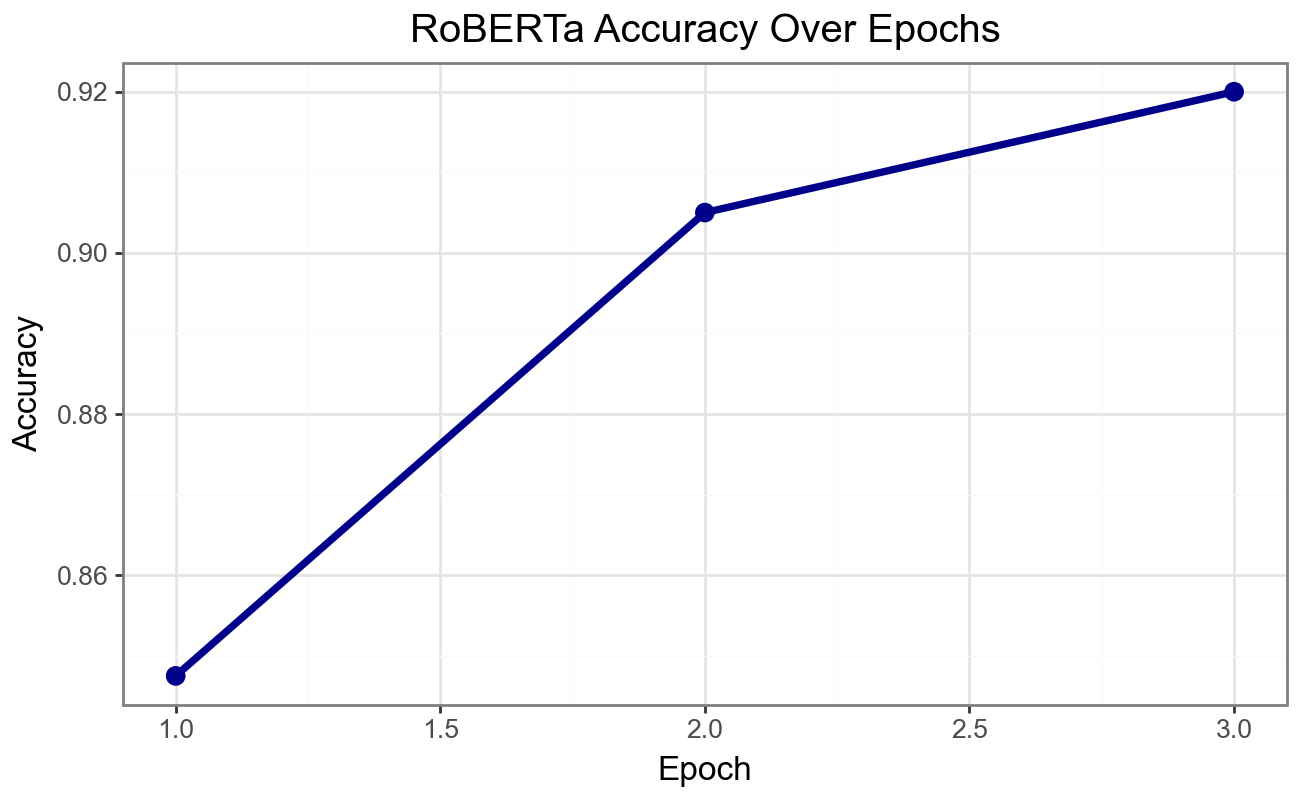

In [9]:
# Import plotting library
import plotnine as plt
import pandas as pd

# Convert log history to DataFrame and filter for evaluation metrics
log_df = pd.DataFrame(trainer.state.log_history)
eval_df = log_df[log_df['eval_accuracy'].notna()].copy()

# Create plot
plot = (plt.ggplot(eval_df, plt.aes(x='epoch', y='eval_accuracy')) +
    plt.geom_line(size=1.5, color='darkblue') +
    plt.geom_point(size=3, color='darkblue') +
    # Set titles and labels
    plt.ggtitle('RoBERTa Accuracy Over Epochs') +
    plt.xlab('Epoch') +
    plt.ylab('Accuracy') +
    # Customize theme
    plt.theme_bw(base_family = "Arial", base_size = 12) +
    plt.theme(figure_size=(6.5, 4))
)

# Display plot
display(plot)